In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

Instructions for updating:
non-resource variables are not supported in the long term


In [62]:
from matplotlib import font_manager,rc,rcParams
import platform

if platform.system() == 'Windows':
    path = 'c:/windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font',family = font_name)
elif platform.system() == 'Darwin':
    rc('font',family = 'AppleGothic')
else:
    print('Check your OS system')
    
rcParams['axes.unicode_minus'] = False

In [63]:
import seaborn as sns

# Introduction
여지껏 수치적인 데이터에서 작동하는 머신러닝 알고리즘을 살펴보았다. 만일 텍스트가 포함된 데이터를 사용하고 싶다면 수치적인 타입으로 바꿀 수 있는 방법이 있어야한다.

만일 우리가 Tensorflow makes machine learning easy라는 문장을 숫자로 바꾼다고 하자.
1. 1 2 3 4 5로 바꾸는 방법이 있다.<br>

각각의 단어에 숫자를 하나씩 매칭하는 방법이다. 이럴 경우 machine learning is easy라는 문장을 3 4 0 5로 바꿀 수 있다. 0 같은 숫자는 vocabulary사전에 등록되어 있지 않은 모든 단어를 포괄하는 숫자다. <br>
단 이런 방법을 적용할 경우 4에 대응하는 learning이라는 단어를 2에 대응하는 makes의 제곱으로 인식해버리는 경우가 생길 수 있다. 바꿔진 숫자들은 그저 categories에 대한 것이지 단어들간의 관계(relationship)가 아니다. 당연히 이런 방법으로는 단어들간의 관계를 나타낼 수 없다.

2. \[0,1,1,1,1,1\]로 바꾸는 방법이 있다.

주어진 문장은 6개의 단어(5개의 명확한 단어와 1개의 unknown word)로 이루어져있고 각각의 단어 위치에 0 혹은 1을 매칭하는 것이다. 0은 문장내 해당 단어가 없다는 의미, 1은 있다는 의미이다.(one-hot encoding) machine learning is easy 같은 경우는 \[1,0,0,1,1,1\]로 매칭이 된다.<br>
이 방법에도 단점이 있는데 단어들간의 순서를 나타내지 못한다. Tensorflow makes machine learnign easy와 machine learning makes Tensorflow easy는 결과적으로 같은 문장이 되는 것이다.

또 벡터는 우리가 택한 vocabulary 사전의 사이즈와 같아질 것이라는 것도 염두에 두어야한다. 보통 매우 큰 vocabulary 사전을 다루게 될 것이므로 문장 벡터는 매우 sparse해질 것이다. 이런 타입의 임베딩(embedding, 단어를 벡터로 표현하는 방법)을 bag-of-words라고 부른다.

또 생각해봐야할 것은 is와 Tensorflow가 같은 수치 1을 갖는다는 것이다. 거의 모든 경우에 is는 Tensorflow보다 의미적으로 덜 중요할 것이라는 것은 분명하다.

이번 chapter를 통해 다른 타입의 임베딩을 살펴보도록 한다.

# Working with bag-of-words embeddings
다음의 데이터를 이용한다 : https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection<br>
스팸문자와 일반문자를 모아놓은 데이터이다. 모델은 은닉층이 없는 logistic 회귀, 배치 사이즈는 1을 사용해 accuracy를 계산할 것이다.

In [2]:
# 1.
sess = tf.Session()
import csv
import string
import requests
import io, os
from zipfile import ZipFile

In [4]:
# 2. 이미 다운로드를 완료한 상황
z = ZipFile('smsspamcollection.zip','r')
file = z.read('SMSSpamCollection')

In [10]:
text_data = file.decode()
# 원하는 형식으로 encoding한 후
text_data2 = text_data.encode('ascii',errors='ignore')
# 다시 decode
text_data3 = text_data2.decode().split('\n')

In [92]:
text_data4 = [x.split('\t') for x in text_data3 if len(x)>=1]

In [93]:
text_df = pd.DataFrame(text_data4,columns=['target','sentence'])
text_df.head()

,target,sentence
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [94]:
temp_dict = {'spam':1,'ham':0}
text_df['target'] = text_df['target'].map(temp_dict)
text_df.head()

,target,sentence
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [95]:
# 3. potential vocabulary size를 작게 만들기 위해 대소문자를 통일하고 텍스트 내의 숫자를 없애기로 한다.

# 소문자로 통일
text_df['sentence'] = text_df['sentence'].map(lambda x:x.lower())

In [112]:
targets = text_df['target']

In [97]:
# 특수문자, number 제거
texts = [x.lower() for x in text_df['sentence']]

# Remove punctuation
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts]

# Remove numbers
texts = [''.join(c for c in x if c not in '0123456789') for x in texts]

# Trim extra whitespace
texts = [' '.join(x.split()) for x in texts]

최대길이 :  171
최소길이 :  0


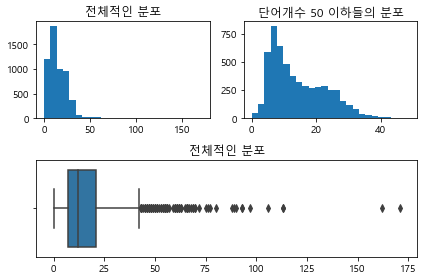

In [98]:
# 4. 그래프(히스토그램)를 그려 문장 내 단어 개수의 분포를 확인

text_lengths = [len(x.split()) for x in texts]
text_lengths_50 = [x for x in text_lengths if x < 50]

print('최대길이 : ',np.array(text_lengths).max())
print('최소길이 : ',np.array(text_lengths).min())

grid = plt.GridSpec(2, 2)
ax1 = plt.subplot(grid[0, 0])
ax2 = plt.subplot(grid[0, 1])
ax3 = plt.subplot(grid[1, 0:]) 

ax1.hist(text_lengths,bins=25)
ax2.hist(text_lengths_50,bins=25)
sns.boxplot(text_lengths,ax=ax3)

ax1.set_title('전체적인 분포')
ax2.set_title('단어개수 50 이하들의 분포')
ax3.set_title('전체적인 분포')

plt.tight_layout()

In [99]:
# 5. 25를 단어개수의 최대 사이즈로 설정
sentence_size = 25
min_word_freq = 3

In [100]:
# 책에는 tf.contrib.learn 패키지를 이용하고 있지만 2버전에서 삭제되었다. 대신 scikt-learn을 이용
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df = min_word_freq,max_df=sentence_size)

In [170]:
transformed_text = np.array(vect.transform(texts))
transformed_text

array(<5574x2371 sparse matrix of type '<class 'numpy.int64'>'
	with 15608 stored elements in Compressed Sparse Row format>, dtype=object)

In [177]:
tf.SparseTensor(vect.fit_transform(text_train))

TypeError: __init__() missing 2 required positional arguments: 'values' and 'dense_shape'

In [171]:
feature_names = vect.get_feature_names()
embedding_size = len(feature_names)

In [172]:
embedding_size

2371

In [115]:
# 6.
from sklearn.model_selection import train_test_split
text_train,text_text,target_train,target_text = train_test_split(texts,targets,test_size=0.2)

In [164]:
# 7. embedding matrix for words : 원-핫 인코딩된 sparse text vector를 받기 위함
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

In [165]:
# 8. logistic regression을 수행
A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

x_data = tf.placeholder(shape=[sentence_size],dtype=tf.int32)
y_target = tf.placeholder(shape=[1,1],dtype=tf.float32)

In [166]:
# 9. 텐서플로우의 embedding_lookup 함수 : 문장 내에서 단어의 인덱스를 원핫인코딩 벡터에 map해준다.
x_embed = tf.nn.embedding_lookup(identity_mat,x_data)
x_col_sums = tf.reduce_sum(x_embed,0)

# 10.
x_col_sums_2D = tf.expand_dims(x_col_sums,0)
model_output = tf.add(tf.matmul(x_col_sums_2D,A),b)

# 11.
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output,labels=y_target))
prediction = tf.sigmoid(model_output)

my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

In [167]:
# 12, 13
init = tf.global_variables_initializer()
sess.run(init)

loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix,t in enumerate(vect.fit_transform(text_train).toarray()):
    y_data = [[target_train[ix]]]
    sess.run(train_step,feed_dict={x_data:t, y_target:y_data})
    temp_loss = sess.run(loss,feed_dict={x_data:t,y_target:y_data})
    loss_vec.append(temp_loss)
    if (ix+1)%1000:
        print('Training Observation #{}, Loss : {}'.format(ix+1,temp_loss))
    if (ix+1)==4450:
        print('Training Observation #{}, Loss : {}'.format(ix+1,temp_loss))
    [[temp_pred]] = sess.run(prediction,feed_dict={x_data:t,y_target:y_data})
    train_acc_temp = target_train[ix] == np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))

ValueError: Cannot feed value of shape (1941,) for Tensor 'Placeholder_4:0', which has shape '(25,)'

In [140]:
a=1
for i in vect.fit_transform(text_train):
    a+=1
print(a)

4460


In [143]:
temp_scipy = vect.fit_transform(text_train)

In [154]:
a=1
for i in tf.constant(temp_scipy.toarray()):
    a+=1
print(a)

OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed in Graph execution. Use Eager execution or decorate this function with @tf.function.

In [151]:
temp_scipy.shape

(4459, 1941)

# 라이브러리 부재로 일시 중단